In [1]:
%load_ext autoreload
%autoreload 2
'''
Example of how to use the library for learning using the PILCO learner on the cartpole task
'''
# pylint: disable=C0103
import atexit
import sys
import os
import numpy as np
import kusanagi.ghost.regression as kreg

from kusanagi import utils
from kusanagi.shell.cartpole import default_params
from kusanagi.ghost.algorithms.PILCO import PILCO, MC_PILCO
from kusanagi.ghost.control import NNPolicy, RBFPolicy
from kusanagi.utils import plot_results

#np.random.seed(31337)
np.set_printoptions(linewidth=500)

Using cuDNN version 5005 on context None
Mapped name None to device cuda0: GeForce GTX 770 (0000:01:00.0)


In [2]:
# setup output directory
utils.set_output_dir(os.path.join(utils.get_output_dir(), 'cartpole'))

use_bnn = True
J = 4                                                       # number of random initial trials
N = 100                                                     #learning iterations
pilco_config = default_params()
# initialize learner params for PILCO
pilco_config['params']['use_empirical_x0'] = True
pilco_config['params']['realtime'] = False
pilco_config['params']['H'] = 4.0
pilco_config['params']['plant']['dt'] = 0.1
pilco_config['params']['plant']['params']['l'] = .6
pilco_config['params']['cost']['pendulum_length'] = .6

# create copy of params for MC-PILCO
mcpilco_config = pilco_config.copy()
mcpilco_config['params']['min_method'] = 'ADAM'
mcpilco_config['params']['learning_rate'] = 1e-4
mcpilco_config['params']['max_evals'] = 1000
mcpilco_config['params']['clip'] = 10.0
mcpilco_config['n_samples'] = 100
mcpilco_config['dynmodel_class'] = kreg.BNN
mcpilco_config['policy_class'] = RBFPolicy

# init learners
pilco = PILCO(**pilco_config)
mcpilco = MC_PILCO(**mcpilco_config)
mcpilco.resample = False

# share experience and policy between the two learners
mcpilco.experience = pilco.experience
mcpilco.policy = pilco.policy

# gather data with random trials on the pilco learner
for i in range(J):
    pilco.plant.reset_state()
    pilco.apply_controller(random_controls=True)
#pilco.plant.reset_state()
#pilco.apply_controller()

[2017-06-15 22:40:57.746039] RBFPolicy_sat > Initializing parameters
[2017-06-15 22:40:57.820925] RBFPolicy_sat > Initialising expression graph for full GP training loss function
[2017-06-15 22:40:58.117802] RBFPolicy_sat > Initialising expression graph for prediction
[2017-06-15 22:40:58.134578] RBFPolicy_sat > Compiling mean and variance of prediction
[2017-06-15 22:41:21.211059] RBFPolicy_sat > Done compiling
[2017-06-15 22:41:21.229708] Experience > Initialising new experience dataset
[2017-06-15 22:41:21.230543] PILCO > Initialising new PILCO learner
[2017-06-15 22:41:21.232700] RBFPolicy_sat > Initializing parameters
[2017-06-15 22:41:21.246282] RBFPolicy_sat > Initialising expression graph for full GP training loss function
[2017-06-15 22:41:21.415878] RBFPolicy_sat > Initialising expression graph for prediction
[2017-06-15 22:41:21.430355] RBFPolicy_sat > Compiling mean and variance of prediction
[2017-06-15 22:41:22.355605] RBFPolicy_sat > Done compiling
[2017-06-15 22:41:22.3

In [3]:
pilco.train_dynamics()

[2017-06-15 22:41:29.214750] PILCO > Training dynamics model
[2017-06-15 22:41:29.233473] GP_UI > Unable to load state from /home/thalassa/gamboa/.kusanagi/output/cartpole/PILCO_GP_UI_6_4_Cartpole_RBFPolicy_sat_dynamics.zip
[Errno 2] No such file or directory: '/home/thalassa/gamboa/.kusanagi/output/cartpole/PILCO_GP_UI_6_4_Cartpole_RBFPolicy_sat_dynamics.zip'
[2017-06-15 22:41:29.237665] GP_UI > Initialising parameters
[2017-06-15 22:41:29.239837] PILCO > Dataset size:: Inputs: [ (160, 6) ], Targets: [ (160, 4) ]  
[2017-06-15 22:41:29.240897] GP_UI > Initialising expression graph for full GP training loss function
[2017-06-15 22:41:29.436299] GP_UI > Compiling full GP training loss function
[2017-06-15 22:41:36.823663] GP_UI > Compiling gradient of full GP training loss function
[2017-06-15 22:42:14.538456] GP_UI > Current hyperparameters:
[gpuarray.array([[ 0.62565835,  0.09183975,  0.85587254, -1.09749422, -1.37403758,  1.00258878, -2.22086857, -4.52345366],
       [ 0.62565835,  0

In [4]:
mcpilco.train_dynamics(max_episodes=4)

[2017-06-15 11:55:37.784506] MC_PILCO > Training dynamics model
[2017-06-15 11:55:37.809248] BNN > Unable to load state from /home/thalassa/gamboa/.kusanagi/output/cartpole/MC_PILCO_BNN_6_4_Cartpole_RBFPolicy_sat_dynamics.zip
[Errno 2] No such file or directory: '/home/thalassa/gamboa/.kusanagi/output/cartpole/MC_PILCO_BNN_6_4_Cartpole_RBFPolicy_sat_dynamics.zip'
[2017-06-15 11:55:37.814322] MC_PILCO > Dataset size:: Inputs: [ (160, 6) ], Targets: [ (160, 4) ]  
[2017-06-15 11:55:37.823292] BNN > Building network
('InputLayer', {'shape': (None, 6), 'name': 'BNN_input'})
('DenseLayer', {'name': 'BNN_fc0', 'nonlinearity': <function selu at 0x7f7e66af5488>, 'num_units': 200})
('DropoutLayer', {'rescale': False, 'p': 0.05, 'name': 'BNN_drop0', 'dropout_samples': array(100, dtype=int32)})
('DenseLayer', {'name': 'BNN_fc1', 'nonlinearity': <function selu at 0x7f7e66af5488>, 'num_units': 200})
('DropoutLayer', {'rescale': False, 'p': 0.05, 'name': 'BNN_drop1', 'dropout_samples': array(100, dt

[2017-06-15 11:55:54.583908] MC_PILCO > Computing symbolic expression graph for belief state propagation
[2017-06-15 11:55:55.342376] MC_PILCO > Compiling trajectory rollout function
[2017-06-15 11:55:57.759849] MC_PILCO > Done compiling.


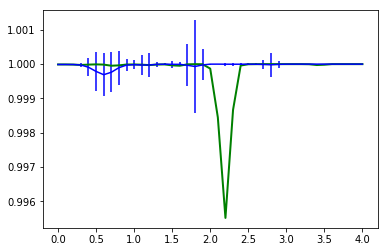

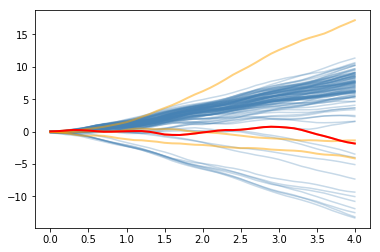

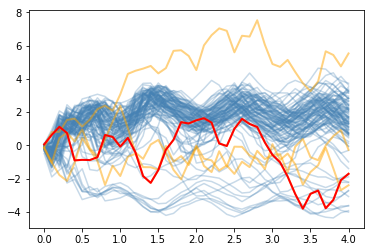

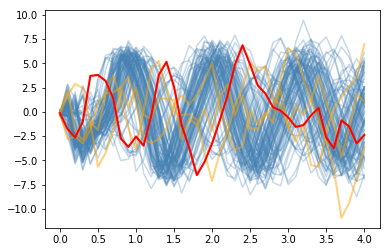

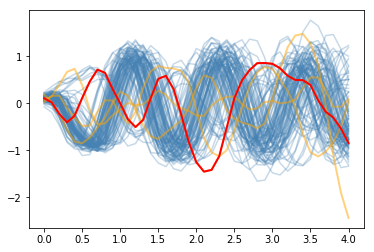

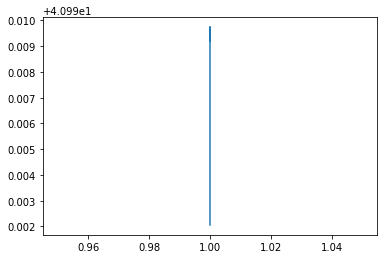

/localdata/juan/miniconda2/lib/python2.7/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


In [5]:
mcpilco.resample = False
mcpilco.rollout_fn = None
mcpilco.set_n_samples(100)
plot_results(mcpilco,plot_samples=True)

[2017-06-15 11:56:07.129365] MC_PILCO > Computing symbolic expression graph for belief state propagation
[2017-06-15 11:56:07.993706] MC_PILCO > Compiling trajectory rollout function
[2017-06-15 11:56:11.092300] MC_PILCO > Done compiling.


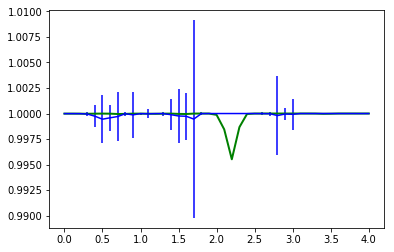

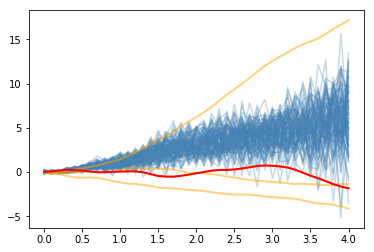

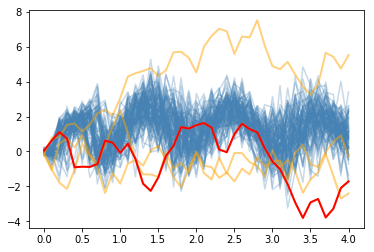

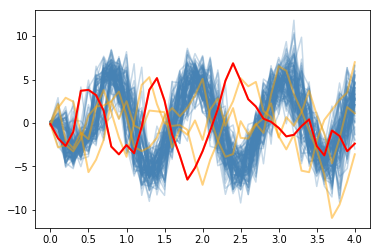

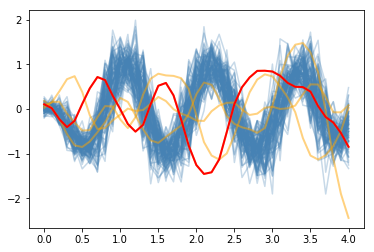

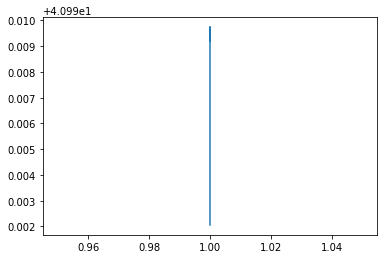

In [6]:
mcpilco.resample = True
mcpilco.rollout_fn = None
mcpilco.set_n_samples(100)
plot_results(mcpilco,plot_samples=True)

In [7]:
plot_results(pilco)

[2017-06-15 11:56:21.083928] PILCO > Computing symbolic expression graph for belief state propagation


ValueError: When compiling the inner function of scan the following error has been encountered: The initial state (`outputs_info` in scan nomenclature) of variable IncSubtensor{Set;:int64:}.0 (argument number 0) has dtype float32, while the result of the inner function (`fn`) has dtype float64. This can happen if the inner function of scan results in an upcast or downcast.

In [8]:
#resample = True
#n_samples = 25
#mcpilco.learning_rate = 1e-4
#if mcpilco.trajectory_samples.get_value() != n_samples or mcpilco.resample != resample:
#    mcpilco.resample = resample
#    mcpilco.set_n_samples(n_samples)
#    mcpilco.rollout_fn = None
#    mcpilco.train_fn = None
mcpilco.set_n_samples(100)
mcpilco.learning_rate = 1e-3
# train
mcpilco.train_policy()
# apply controller
mcpilco.plant.reset_state()
mcpilco.apply_controller()

[2017-06-15 11:56:25.623879] MC_PILCO > Training policy parameters [Iteration 1]
[2017-06-15 11:56:25.692670] MC_PILCO > Initial value estimate [39.837166]
[2017-06-15 11:56:25.693653] MC_PILCO > Using ADAM optimizer
[2017-06-15 11:56:25.694255] MC_PILCO > Computing symbolic expression graph for belief state propagation
[2017-06-15 11:56:26.234083] MC_PILCO > Compiling optimizer
[2017-06-15 11:56:26.235139] MC_PILCO > Computing symbolic expression for policy gradients
[2017-06-15 11:56:58.957325] MC_PILCO > Done compiling.
[2017-06-15 12:01:46.519987] MC_PILCO > Current value: 3.699680E+01, Total evaluations: 1000, gm: [9.0935793, 3.6229255, 2.0448065], lr: 0.0010000
[2017-06-15 12:01:46.598333] MC_PILCO > Done training. New value [37.308384] iter: [561]
[2017-06-15 12:01:46.599680] Cartpole > Reset to inital state
[2017-06-15 12:01:46.601033] MC_PILCO > Compiling cost function
[2017-06-15 12:01:46.602071] MC_PILCO > Cost parameters: {'width': 0.25, 'pendulum_length': 0.6, 'angle_dims'

In [9]:
#mcpilco.save()

In [5]:
import theano
mx = theano.tensor.vector('mx')
Sx = theano.tensor.matrix('Sx')
M,S,C = pilco.dynamics_model.predict_symbolic(mx,Sx)

In [ ]:
jac = theano.tensor.jacobian()